In [10]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import torch
from torch import nn
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from torchvision import transforms, datasets, models
from torchvision.models import resnet50, densenet121, inception_v3
from torchsummary import summary
from collections import OrderedDict
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns
import wandb
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold

In [11]:
BATCH_SIZE = 4

In [12]:
class AugmentedDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=False):
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        self.train = train
        self.classes = self.dataset.classes
        self.class_to_idx = self.dataset.class_to_idx
        
        self.augment_classes = ['None', 'Many']
        self.augment_indices = [self.class_to_idx[cls] for cls in self.augment_classes if cls in self.class_to_idx]
        
        # Count samples per class
        self.class_counts = [0] * len(self.classes)
        for _, label in self.dataset.samples:
            self.class_counts[label] += 1
        
        # Calculate class weights once
        total_samples = sum(self.class_counts)
        self.class_weights = [total_samples / (len(self.class_counts) * count) for count in self.class_counts]
        
        if self.train:
            self.train_augs = A.Compose([
                A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  # Reduced limits
                A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),  # Reduced upper var_limit
                A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.1, rotate_limit=10, p=0.5),])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        
        if self.train and label in self.augment_indices:
            img_np = np.array(img)
            augmented = self.train_augs(image=img_np)
            img_np = augmented['image']
            img = Image.fromarray(img_np)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

    def get_sample_weights(self):
        return [self.class_weights[label] for _, label in self.dataset.samples]

In [13]:
def create_weighted_sampler(dataset, indices):
    sample_weights = dataset.get_sample_weights()
    subset_weights = [sample_weights[i] for i in indices]
    return WeightedRandomSampler(subset_weights, len(subset_weights), replacement=True)

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Create full datasets
full_dataset = AugmentedDataset('data', transform=transform)
print(len(full_dataset))
print(full_dataset.class_counts)
print(sum(full_dataset.class_counts))
dummy_loader = DataLoader(full_dataset, batch_size=1, shuffle=True)

8724
[6232, 256, 2236]
8724


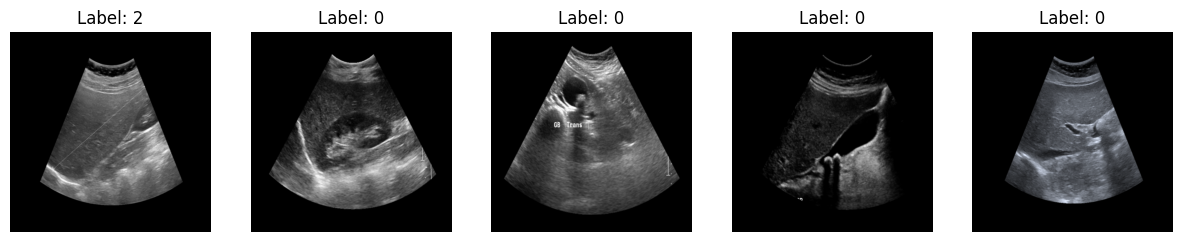

In [14]:
# Function to get images of a specific label
def get_images_by_label(dataloader, num_images=1, label=None):
    images = []
    labels = []
    if label is None:
        # Get random images not considering the label
        for batch_images, batch_labels in dataloader:
            for img, lbl in zip(batch_images, batch_labels):
                images.append(img)
                labels.append(lbl)
                if len(images) >= num_images:
                    return images, labels
    for batch_images, batch_labels in dataloader:
        for img, lbl in zip(batch_images, batch_labels):
            if lbl == label:
                images.append(img)
                labels.append(lbl)
                if len(images) >= num_images:
                    return images, labels
    return images, labels

# Example usage: Get 5 images of label 0
label_to_display = 2
num_images_to_display = 5
images, labels = get_images_by_label(dummy_loader, num_images_to_display, label=None)

# Display the images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))
for i, (img, lbl) in enumerate(zip(images, labels)):
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(f'Label: {lbl}')
    axes[i].axis('off')
plt.show()

In [15]:
num_class = len(dummy_loader.dataset.classes)
print(num_class)
print(dummy_loader.dataset.classes)

3
['Few', 'Many', 'None']


In [16]:
class_weights = torch.tensor(full_dataset.class_weights, dtype=torch.float)
print(class_weights)
print(full_dataset.classes)

tensor([ 0.4666, 11.3594,  1.3005])
['Few', 'Many', 'None']


In [17]:
for batch in dummy_loader:
    print(batch)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]), tensor([0])]


In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

def calculate_metrics(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate metrics for each class
    metrics = []
    sensitivities = []
    specificities = []
    
    for i in range(len(cm)):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - TP - FP - FN
        
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        
        metrics.append({
            'sensitivity': sensitivity,
            'specificity': specificity
        })
    
    # Calculate overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate ROC-AUC
    auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
    
    # Calculate averaged sensitivity and specificity
    avg_sensitivity = sum(sensitivities) / len(sensitivities) if sensitivities else 0
    avg_specificity = sum(specificities) / len(specificities) if specificities else 0
    
    return accuracy, metrics, auc, cm, avg_sensitivity, avg_specificity

def plot_confusion_matrix(cm, class_names, epoch_num=0, model_name='model', fold_num=0):
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'figures/confusion_matrix_{model_name}_epoch_{epoch_num}_fold{fold_num}.png')
    plt.close()

def custom_log(metrics, model_name, log_dir='logs'):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    log_file = f'{log_dir}/{model_name}_metrics_log.json'
    with open(log_file, 'a') as f:
        f.write(json.dumps(metrics) + '\n')

In [19]:
class Classifier(nn.Module):
    def __init__(self, num_class, in_features=2048):
        super().__init__()
        self.drop_out = nn.Dropout()
        self.linear = nn.Linear(in_features, num_class)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.drop_out(x)
        x = self.linear(x)
        #x = torch.softmax(x, dim=-1)
        return x

class InceptionBackbone(nn.Module):
    def __init__(self, path, num_classes):
        super().__init__()
        base_model = inception_v3(weights=None, aux_logits=False)
        encoder_layers = list(base_model.children())
        self.backbone = nn.Sequential(*encoder_layers[:-1])
        
        state_dict = torch.load(path)
        new_state_dict = {}
        for k, v in state_dict.items():
            new_state_dict[k[9:]] = v

        print(self.backbone.load_state_dict(new_state_dict))  # <All keys matched successfully>
        
        self.classifier = Classifier(num_classes)
                        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [20]:
import torch
import torch.nn.functional as F
import numpy as np
import wandb
from sklearn.metrics import f1_score

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=30, device='cuda', model_name='model', fold=0):
    wandb.init(project="Hepatocyte Ballooning Detection", name=f"RadImageNet {model_name} Fold {fold+1}")
    print(f'Training {model_name} for {num_epochs} epochs on Fold {fold+1}')
    min_f1 = np.inf
    best_metrics = {}
    class_names = ['None', 'Few', 'Many']
    
    for e in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []

        for i_batch, batch in enumerate(train_loader):
            data, labels = batch[0].to(device, dtype=torch.float), batch[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds, val_labels, val_probs = [], [], []

        with torch.no_grad():
            for i_batch, batch in enumerate(val_loader):
                data, labels = batch[0].to(device, dtype=torch.float), batch[1].to(device)
                
                outputs = model(data)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * data.size(0)

                probs = F.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.cpu().numpy())

        # Calculate metrics
        val_accuracy, val_class_metrics, val_auc, val_cm, avg_sensitivity, avg_specificity = calculate_metrics(val_labels, val_preds, val_probs)
        macro_f1 = f1_score(val_labels, val_preds, average='macro')

        print(f'Epoch {e+1}')
        val_loss /= len(val_loader.dataset)
        train_loss /= len(train_loader.dataset)
        print(f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')
        print(f'Validation AUC: {val_auc:.4f}')
        print(f'Averaged Sensitivity: {avg_sensitivity:.4f}, Averaged Specificity: {avg_specificity:.4f}')
        print(f'Macro-averaged F1 Score: {macro_f1:.4f}')
        for i, metrics in enumerate(val_class_metrics):
            print(f'Class {class_names[i]} - Sensitivity: {metrics["sensitivity"]:.4f}, Specificity: {metrics["specificity"]:.4f}')

        # Log metrics to wandb and custom logger
        metrics = {
            'fold': fold + 1,
            'epoch': e + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_auc': val_auc,
            'avg_sensitivity': avg_sensitivity,
            'avg_specificity': avg_specificity,
            'macro_f1': macro_f1,
            **{f'class_{class_names[i]}_sensitivity': metrics["sensitivity"] for i, metrics in enumerate(val_class_metrics)},
            **{f'class_{class_names[i]}_specificity': metrics["specificity"] for i, metrics in enumerate(val_class_metrics)}
        }

        # Log to wandb
        wandb.log(metrics)

        # Log to custom logger
        custom_log(metrics, model_name)

        # Save the last model and delete one before it to chekpoint directory
        torch.save(model.state_dict(), f'checkpoints/last_{model_name}_epoch_{e+1}_fold_{fold+1}.pth')
        if e > 0:
            os.remove(f'checkpoints/last_{model_name}_epoch_{e}_fold_{fold+1}.pth')
        
        # Save the best model
        if max_f1 < macro_f1:
            print(f'Macro F1 Increased({min_f1:.6f}--->{macro_f1:.6f}) \t Saving The Model')
            max_f1 = macro_f1
            best_metrics = metrics.deepcopy()
            torch.save(model.state_dict(), f'checkpoints/best/best_{model_name}_epoch_{e+1}_fold_{fold+1}.pth')
            
            # Plot confusion matrix for the best model
            plot_confusion_matrix(val_cm, class_names, e, model_name)

    print("Best Validation Metrics:")
    print(f"Accuracy: {best_metrics['val_accuracy']:.4f}")
    print(f"AUC: {best_metrics['val_auc']:.4f}")
    print(f'Averaged Sensitivity: {best_metrics["avg_sensitivity"]:.4f}, Averaged Specificity: {best_metrics["avg_specificity"]:.4f}')
    print(f'Macro-averaged F1 Score: {best_metrics["macro_f1"]:.4f}')
    for i, metrics in enumerate(best_metrics['val_class_metrics']):
        print(f'Class {class_names[i]} - Sensitivity: {metrics["sensitivity"]:.4f}, Specificity: {metrics["specificity"]:.4f}')
    wandb.finish()

    return model, best_metrics

In [21]:
models = os.listdir('models')
print(models)
model_name = models[2] # InceptionV3

['ResNet50.pt', 'DenseNet121.pt', 'InceptionV3.pt']


In [22]:
# Define the path to the data
data_path = 'data'

# List the folders in the data path
folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

# Initialize a dictionary to store the count of images in each folder
image_counts = {}

# Iterate through each folder and count the number of image files
for folder in folders:
    folder_path = os.path.join(data_path, folder)
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    image_counts[folder] = len(image_files)

# Display the results
for folder, count in image_counts.items():
    print(f'Folder: {folder}, Number of images: {count}')

Folder: None, Number of images: 2236
Folder: Few, Number of images: 6232
Folder: Many, Number of images: 256


In [23]:
# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Iterate through each folder and collect file paths and labels
for folder in folders:
    folder_path = os.path.join(data_path, folder)
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    file_paths.extend([os.path.join(folder_path, img) for img in image_files])
    labels.extend([folder] * len(image_files))

# Convert lists to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_metrics_lst = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(full_dataset, full_dataset.dataset.targets)):
	print(f"Fold {fold + 1}")
	
	# Create training and validation subsets
	train_subset = Subset(full_dataset, train_idx)
	val_subset = Subset(full_dataset, val_idx)
	
	sampler = create_weighted_sampler(full_dataset, train_idx)

	# Create DataLoaders
	train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler)
	val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

	# Load the model
	model_path = f'models/{model_name}'
	model = InceptionBackbone(model_path, num_class).to(device)

	# Define loss function and optimizer
	criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
	optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

	# Train the model
	model, best_metrics = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=30, device=device, model_name=model_name, fold=fold)
	best_metrics_lst.append(best_metrics)
	custom_log(best_metrics, model_name + '_best', log_dir='logs/best')

Fold 1


/home/samo/dev/liver/.venv/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


<All keys matched successfully>


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: samwellwatwat. Use `wandb login --relogin` to force relogin


Training InceptionV3.pt for 30 epochs on Fold 1
